In [1]:
# Install required packages
!pip -q install -U transformers accelerate sentencepiece datasets scikit-learn tqdm pandas matplotlib seaborn bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import os, re, json, math, random, time
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSeq2SeqLM,
    BitsAndBytesConfig
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

Using device: cuda


## Load Pre-existing Dataset

In [3]:
# Load your dataset - modify this path to your actual dataset location
# Expected format: CSV or JSON with columns: statement, isHallucination, topic

def load_dataset(filepath: str) -> pd.DataFrame:
    """
    Load the pre-existing dataset with facts and hallucinations.
    Expected columns: statement, isHallucination ("yes"/"no"), topic
    """
    if filepath.endswith('.csv'):
        df = pd.read_csv(filepath)
    elif filepath.endswith('.json') or filepath.endswith('.jsonl'):
        df = pd.read_json(filepath, lines=filepath.endswith('.jsonl'))
    else:
        raise ValueError("Unsupported file format. Use CSV or JSON/JSONL")

    # Standardize column names if needed
    df.columns = df.columns.str.strip()

    # Convert isHallucination to YES/NO format if needed
    if df['isHallucination'].dtype == bool:
        df['isHallucination'] = df['isHallucination'].map({True: 'YES', False: 'NO'})
    elif df['isHallucination'].str.lower().isin(['yes', 'no']).all():
        df['isHallucination'] = df['isHallucination'].str.upper()

    print(f"Loaded {len(df)} statements from {len(df['topic'].unique())} topics")
    print(f"Topics: {', '.join(df['topic'].unique()[:5])}...")
    print(f"Facts: {(df['isHallucination'] == 'NO').sum()}")
    print(f"Hallucinations: {(df['isHallucination'] == 'YES').sum()}")

    return df

# MODIFY THIS PATH to your actual dataset file
# Example: '/content/drive/MyDrive/halluverse_dataset.csv'
DATASET_PATH = 'facts_hallucinations_dataset.csv'  # Change this!

# Uncomment and modify when you have your dataset
df_dataset = load_dataset(DATASET_PATH)

print(f"Created sample dataset with {len(df_dataset)} entries")

Loaded 1200 statements from 20 topics
Topics: M. S. Dhoni, A. P. J. Abdul Kalam, Sachin Tendulkar, Srinivasa Ramanujan, Indira Gandhi...
Facts: 600
Hallucinations: 600
Created sample dataset with 1200 entries


## Load External Knowledge Source for Enhanced Retrieval

In [4]:
# Enhanced retrieval system with on-the-fly knowledge fetching
import requests
from typing import List, Dict

class EnhancedRetriever:
    """
    Enhanced retriever that can fetch relevant information on-the-fly
    for better context in Self-RAG
    """

    def __init__(self):
        self.vectorizer = None
        self.knowledge_base = {}
        self.topic_contexts = {}

    def build_knowledge_base(self, df: pd.DataFrame):
        """
        Build a knowledge base from the dataset topics
        """
        topics = df['topic'].unique()

        for topic in tqdm(topics, desc="Building knowledge base"):
            # Collect all non-hallucinated statements for this topic
            facts = df[(df['topic'] == topic) & (df['isHallucination'] == 'NO')]['statement'].tolist()
            self.topic_contexts[topic] = facts

            # Create a mini knowledge base per topic
            if facts:
                vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.95)
                try:
                    vectorizer.fit(facts)
                    self.knowledge_base[topic] = {
                        'facts': facts,
                        'vectorizer': vectorizer,
                        'vectors': vectorizer.transform(facts)
                    }
                except:
                    # Handle case where facts are too similar or too few
                    self.knowledge_base[topic] = {
                        'facts': facts,
                        'vectorizer': None,
                        'vectors': None
                    }

    def retrieve_context(self, statement: str, topic: str, top_k: int = 3) -> List[str]:
        """
        Retrieve relevant context for a statement
        """
        if topic not in self.knowledge_base:
            return []

        kb = self.knowledge_base[topic]

        if kb['vectorizer'] is None or kb['vectors'] is None:
            # Return random facts if vectorizer failed
            return kb['facts'][:top_k] if kb['facts'] else []

        try:
            query_vec = kb['vectorizer'].transform([statement])
            similarities = cosine_similarity(query_vec, kb['vectors']).flatten()
            top_indices = np.argsort(similarities)[-top_k:][::-1]

            return [kb['facts'][i] for i in top_indices]
        except:
            return kb['facts'][:top_k] if kb['facts'] else []

    def get_enhanced_context(self, statement: str, topic: str) -> str:
        """
        Get enhanced context with retrieval and formatting
        """
        retrieved = self.retrieve_context(statement, topic, top_k=3)

        if retrieved:
            context = f"Topic: {topic}\n\nRelevant Information:\n"
            for i, fact in enumerate(retrieved, 1):
                context += f"{i}. {fact}\n"
            return context
        else:
            return f"Topic: {topic}\n\nNo specific information available."

# Initialize the enhanced retriever
retriever = EnhancedRetriever()
retriever.build_knowledge_base(df_dataset)

Building knowledge base: 100%|██████████| 20/20 [00:00<00:00, 178.72it/s]


## Load Translation Model (NLLB for Multi-lingual)

In [6]:
# NLLB model for translation (distilled version for efficiency)
NLLB_ID = "facebook/nllb-200-distilled-600M"

print("Loading NLLB translation model...")
nllb_tokenizer = AutoTokenizer.from_pretrained(NLLB_ID)
nllb_model = AutoModelForSeq2SeqLM.from_pretrained(
    NLLB_ID,
    torch_dtype=torch.float16,
    device_map="auto"
)

# Language codes for NLLB
LANG_CODES = {
    "en": "eng_Latn",
    "ta": "tam_Taml",
    "hi": "hin_Deva",
    "ma":  "mar_Deva",
    "ka":  "kan_Knda",
}

def nllb_translate_batch(texts: List[str], src_lang: str, tgt_lang: str, batch_size: int = 8) -> List[str]:
    """
    Batch translation using NLLB
    """
    if src_lang not in LANG_CODES or tgt_lang not in LANG_CODES:
        return texts

    src_code = LANG_CODES[src_lang]
    tgt_code = LANG_CODES[tgt_lang]

    nllb_tokenizer.src_lang = src_code
    forced_bos_token_id = nllb_tokenizer.convert_tokens_to_ids(tgt_code)

    translations = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = nllb_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=256
        ).to(nllb_model.device)

        with torch.no_grad():
            outputs = nllb_model.generate(
                **inputs,
                forced_bos_token_id=forced_bos_token_id,
                max_new_tokens=256,
                num_beams=4,
                temperature=0.7
            )

        batch_translations = nllb_tokenizer.batch_decode(outputs, skip_special_tokens=True)
        translations.extend(batch_translations)

    return translations

print("NLLB model loaded successfully!")

Loading NLLB translation model...


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

NLLB model loaded successfully!


## Load Both LLMs: Sarvam-1 and Gemma 2

In [ ]:
from huggingface_hub import login
import os

# Option A: paste your token directly (avoid hard-coding in shared code)
#login(token="REMOVED_TOKEN")

login(os.getenv("HF_TOKEN"))

# Option B: prompt securely (no echo) in many environments
# login()


In [9]:
# Configure quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Dictionary to store models and tokenizers
models = {}
tokenizers = {}

# 1. Load Sarvam-1 (2B)
print("Loading Sarvam-1 model...")
sarvam_id = "sarvamai/sarvam-1"

tokenizers['sarvam'] = AutoTokenizer.from_pretrained(sarvam_id, trust_remote_code=True)
models['sarvam'] = AutoModelForCausalLM.from_pretrained(
    sarvam_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# Add padding token if not present
if tokenizers['sarvam'].pad_token is None:
    tokenizers['sarvam'].pad_token = tokenizers['sarvam'].eos_token

print("Sarvam-1 loaded successfully!")

# 2. Load Gemma 2 (2B)
print("\nLoading Gemma 2 model...")
gemma_id = "google/gemma-2-2b-it"  # Using instruction-tuned version

tokenizers['gemma'] = AutoTokenizer.from_pretrained(gemma_id)
models['gemma'] = AutoModelForCausalLM.from_pretrained(
    gemma_id,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16
)

# Add padding token if not present
if tokenizers['gemma'].pad_token is None:
    tokenizers['gemma'].pad_token = tokenizers['gemma'].eos_token

print("Gemma 2 loaded successfully!")
print("\nBoth models loaded and ready!")

Loading Sarvam-1 model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Sarvam-1 loaded successfully!

Loading Gemma 2 model...


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Gemma 2 loaded successfully!

Both models loaded and ready!


## Define Prompt Templates and Inference Functions

In [15]:
def build_prompt(statement: str, context: str = "", model_name: str = "sarvam") -> str:
    """
    Build appropriate prompt for each model
    """
    if model_name == "gemma":
        # Gemma format
        if context:
            prompt = f"""<start_of_turn>user
Given the following context, determine if the statement is supported (YES) or not supported (NO).

Context: {context}

Statement: {statement}

Answer with only YES or NO.<end_of_turn>
<start_of_turn>model
"""
        else:
            prompt = f"""<start_of_turn>user
Is the following statement factually correct? Answer with only YES or NO.

Statement: {statement}<end_of_turn>
<start_of_turn>model
"""
    else:
        # Sarvam format (or default)
        if context:
            prompt = f"""Given the context below, determine if the statement is supported.

Context: {context}

Statement: {statement}

Answer (YES/NO):"""
        else:
            prompt = f"""Is this statement factually correct?

Statement: {statement}

Answer (YES/NO):"""

    return prompt

def normalize_answer(text: str) -> str:
    """
    Extract YES/NO from model output
    """
    text = text.strip().upper()

    # Look for YES or NO
    if "YES" in text and "NO" not in text:
        return "YES"
    elif "NO" in text:
        return "NO"
    elif "TRUE" in text:
        return "YES"
    elif "FALSE" in text:
        return "NO"
    else:
        # Default to NO if unclear
        return "NO"

def model_batch_answer(
    prompts: List[str],
    model_name: str = "sarvam",
    batch_size: int = 16
) -> List[str]:
    """
    Get batch predictions from specified model
    """
    model = models[model_name]
    tokenizer = tokenizers[model_name]

    predictions = []

    for i in tqdm(range(0, len(prompts), batch_size), desc=f"Processing with {model_name}"):
        batch = prompts[i:i+batch_size]

        # Tokenize
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # Generate
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                temperature=0.1,
                do_sample=True,
                pad_token_id=tokenizer.pad_token_id
            )

        # Decode only the generated tokens
        generated_tokens = outputs[:, inputs['input_ids'].shape[1]:]
        batch_outputs = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

        # Normalize answers
        for output in batch_outputs:
            predictions.append(normalize_answer(output))

    return predictions

## Evaluation Pipeline

In [21]:
def evaluate_model_on_dataset(
    df: pd.DataFrame,
    model_name: str,
    use_context: bool = False,
    use_selfrag: bool = False,
    language: str = "en"
) -> Dict:
    """
    Evaluate a model on the dataset
    """
    results = []
    prompts = []

    # Translate if needed
    if language != "en":
        statements = nllb_translate_batch(
            df['statement'].tolist(),
            src_lang="en",
            tgt_lang=language
        )
    else:
        statements = df['statement'].tolist()

    # Build prompts
    for idx, row in df.iterrows():
        statement = statements[idx]

        if use_context:
            if use_selfrag:
                # Self-RAG: Check if retrieval improves confidence
                context = retriever.get_enhanced_context(row['statement'], row['topic'])

                # First pass without context
                prompt_no_context = build_prompt(statement, "", model_name)

                # Second pass with context
                prompt_with_context = build_prompt(statement, context, model_name)

                # For Self-RAG, we'll use the context version
                # In a full implementation, we'd compare confidence scores
                prompts.append(prompt_with_context)
            else:
                # Regular context-based
                context = retriever.get_enhanced_context(row['statement'], row['topic'])
                prompts.append(build_prompt(statement, context, model_name))
        else:
            # No context
            prompts.append(build_prompt(statement, "", model_name))

    # Get predictions
    predictions = model_batch_answer(prompts, model_name)

    # Calculate metrics
    gold_labels = df['isHallucination'].map({'YES': 'NO', 'NO': 'YES'}).tolist()

    accuracy = accuracy_score(gold_labels, predictions)
    f1 = f1_score(gold_labels, predictions, pos_label='YES', average='binary')

    return {
        'model': model_name,
        'language': language,
        'use_context': use_context,
        'use_selfrag': use_selfrag,
        'predictions': predictions,
        'gold': gold_labels,
        'accuracy': accuracy,
        'f1': f1
    }

def run_full_evaluation(df: pd.DataFrame) -> Dict:
    """
    Run complete evaluation across models and configurations
    """
    results = {}
    configurations = [
        ('baseline', False, False),
        ('selfrag', True, True)
    ]

    languages = ['en', 'ta', 'hi', 'ka', 'ma']
    model_names = ['sarvam', 'gemma']

    for model_name in model_names:
        results[model_name] = {}

        for config_name, use_context, use_selfrag in configurations:
            results[model_name][config_name] = {}

            for lang in languages:
                print(f"\nEvaluating {model_name} - {config_name} - {lang}")

                eval_result = evaluate_model_on_dataset(
                    df,
                    model_name=model_name,
                    use_context=use_context,
                    use_selfrag=use_selfrag,
                    language=lang
                )

                results[model_name][config_name][lang] = eval_result

                print(f"Accuracy: {eval_result['accuracy']:.3f}")
                print(f"F1 Score: {eval_result['f1']:.3f}")

    return results

## Run Evaluation

In [22]:
# Run the full evaluation
print("Starting evaluation...")
print("=" * 50)

# Run evaluation
all_results = run_full_evaluation(df_dataset)

print("\n" + "=" * 50)
print("Evaluation complete!")

Starting evaluation...

Evaluating sarvam - baseline - en


Processing with sarvam: 100%|██████████| 75/75 [04:23<00:00,  3.52s/it]


Accuracy: 0.890
F1 Score: 0.893

Evaluating sarvam - baseline - ta


Processing with sarvam: 100%|██████████| 75/75 [04:24<00:00,  3.53s/it]


Accuracy: 0.717
F1 Score: 0.748

Evaluating sarvam - baseline - hi


Processing with sarvam: 100%|██████████| 75/75 [04:30<00:00,  3.61s/it]


Accuracy: 0.799
F1 Score: 0.784

Evaluating sarvam - baseline - ka


Processing with sarvam: 100%|██████████| 75/75 [04:25<00:00,  3.54s/it]


Accuracy: 0.672
F1 Score: 0.572

Evaluating sarvam - baseline - ma


Processing with sarvam: 100%|██████████| 75/75 [04:20<00:00,  3.47s/it]


Accuracy: 0.553
F1 Score: 0.239

Evaluating sarvam - selfrag - en


Processing with sarvam: 100%|██████████| 75/75 [07:15<00:00,  5.80s/it]


Accuracy: 0.824
F1 Score: 0.792

Evaluating sarvam - selfrag - ta


Processing with sarvam: 100%|██████████| 75/75 [07:14<00:00,  5.79s/it]


Accuracy: 0.765
F1 Score: 0.730

Evaluating sarvam - selfrag - hi


Processing with sarvam: 100%|██████████| 75/75 [07:15<00:00,  5.80s/it]


Accuracy: 0.842
F1 Score: 0.819

Evaluating sarvam - selfrag - ka


Processing with sarvam: 100%|██████████| 75/75 [07:15<00:00,  5.81s/it]


Accuracy: 0.830
F1 Score: 0.795

Evaluating sarvam - selfrag - ma


Processing with sarvam: 100%|██████████| 75/75 [07:12<00:00,  5.76s/it]


Accuracy: 0.871
F1 Score: 0.853

Evaluating gemma - baseline - en


Processing with gemma: 100%|██████████| 75/75 [02:19<00:00,  1.87s/it]


Accuracy: 0.637
F1 Score: 0.482

Evaluating gemma - baseline - ta


Processing with gemma: 100%|██████████| 75/75 [02:50<00:00,  2.28s/it]


Accuracy: 0.754
F1 Score: 0.799

Evaluating gemma - baseline - hi


Processing with gemma: 100%|██████████| 75/75 [02:36<00:00,  2.08s/it]


Accuracy: 0.723
F1 Score: 0.779

Evaluating gemma - baseline - ka


Processing with gemma: 100%|██████████| 75/75 [03:06<00:00,  2.49s/it]


Accuracy: 0.483
F1 Score: 0.640

Evaluating gemma - baseline - ma


Processing with gemma: 100%|██████████| 75/75 [02:40<00:00,  2.14s/it]


Accuracy: 0.568
F1 Score: 0.697

Evaluating gemma - selfrag - en


Processing with gemma: 100%|██████████| 75/75 [04:41<00:00,  3.76s/it]


Accuracy: 0.872
F1 Score: 0.853

Evaluating gemma - selfrag - ta


Processing with gemma: 100%|██████████| 75/75 [05:10<00:00,  4.14s/it]


Accuracy: 0.971
F1 Score: 0.972

Evaluating gemma - selfrag - hi


Processing with gemma: 100%|██████████| 75/75 [04:58<00:00,  3.98s/it]


Accuracy: 0.891
F1 Score: 0.898

Evaluating gemma - selfrag - ka


Processing with gemma: 100%|██████████| 75/75 [05:30<00:00,  4.41s/it]


Accuracy: 0.731
F1 Score: 0.784

Evaluating gemma - selfrag - ma


Processing with gemma: 100%|██████████| 75/75 [05:02<00:00,  4.03s/it]

Accuracy: 0.677
F1 Score: 0.756

Evaluation complete!


## Results Visualization

Saved: accuracy_all_languages_baseline_vs_selfrag.png


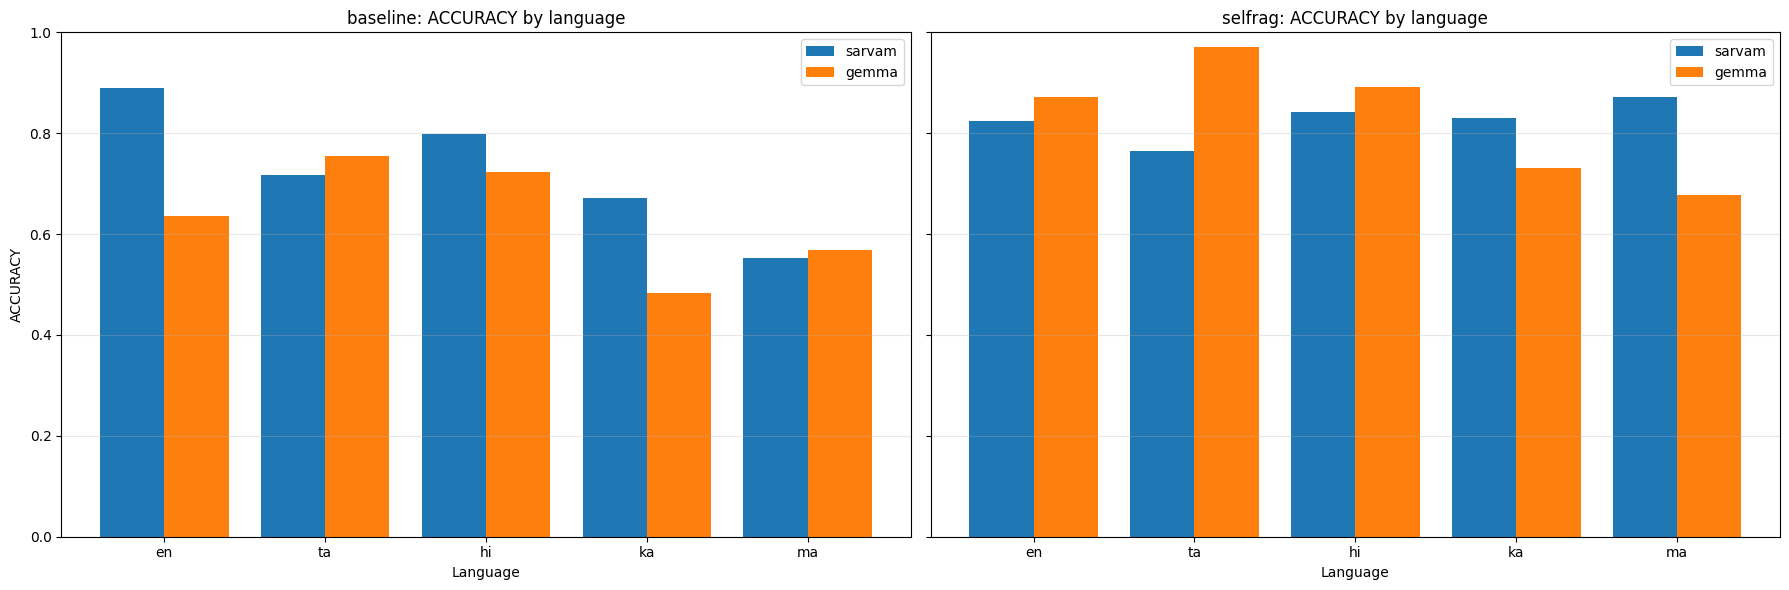

Saved: f1_all_languages_baseline_vs_selfrag.png


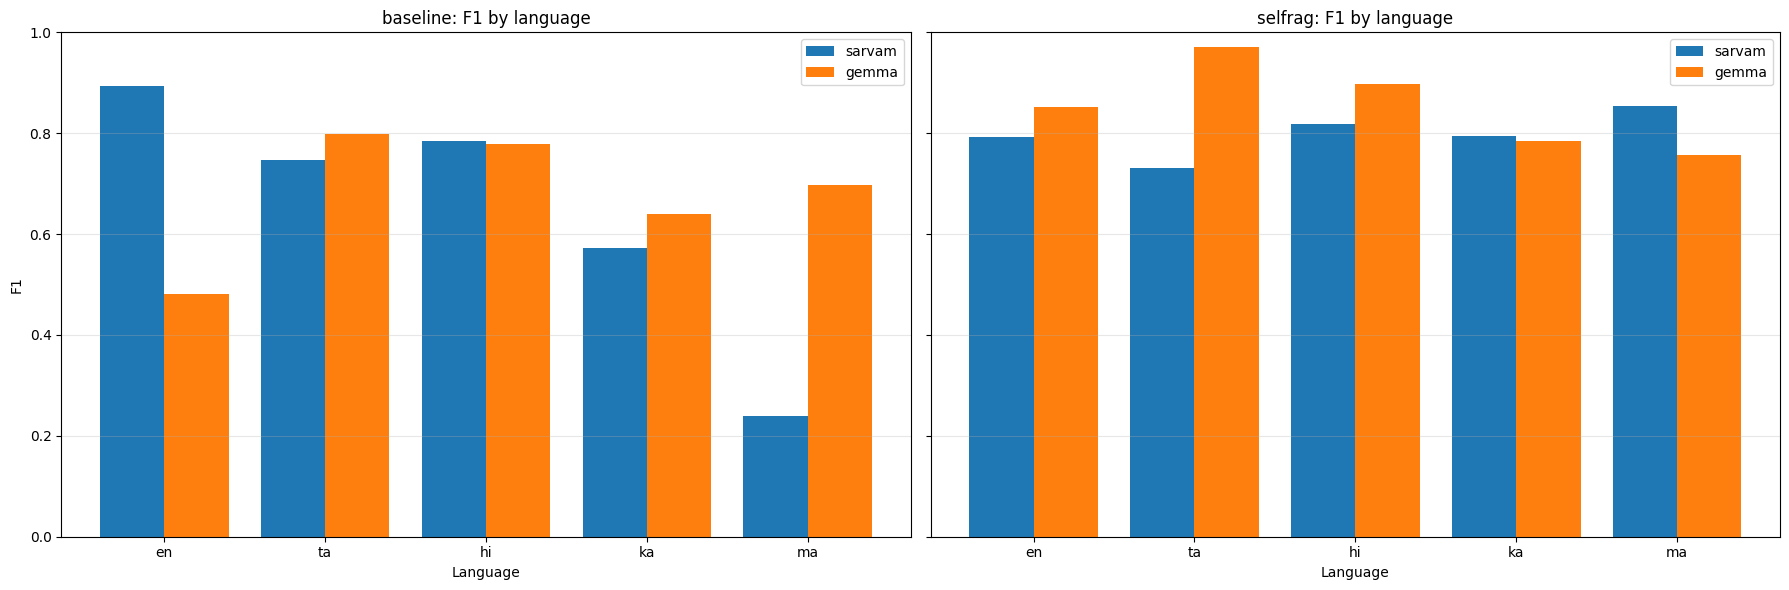

Saved: confusion_summary_all_languages.csv
Saved: confusion_tables_all_languages.png


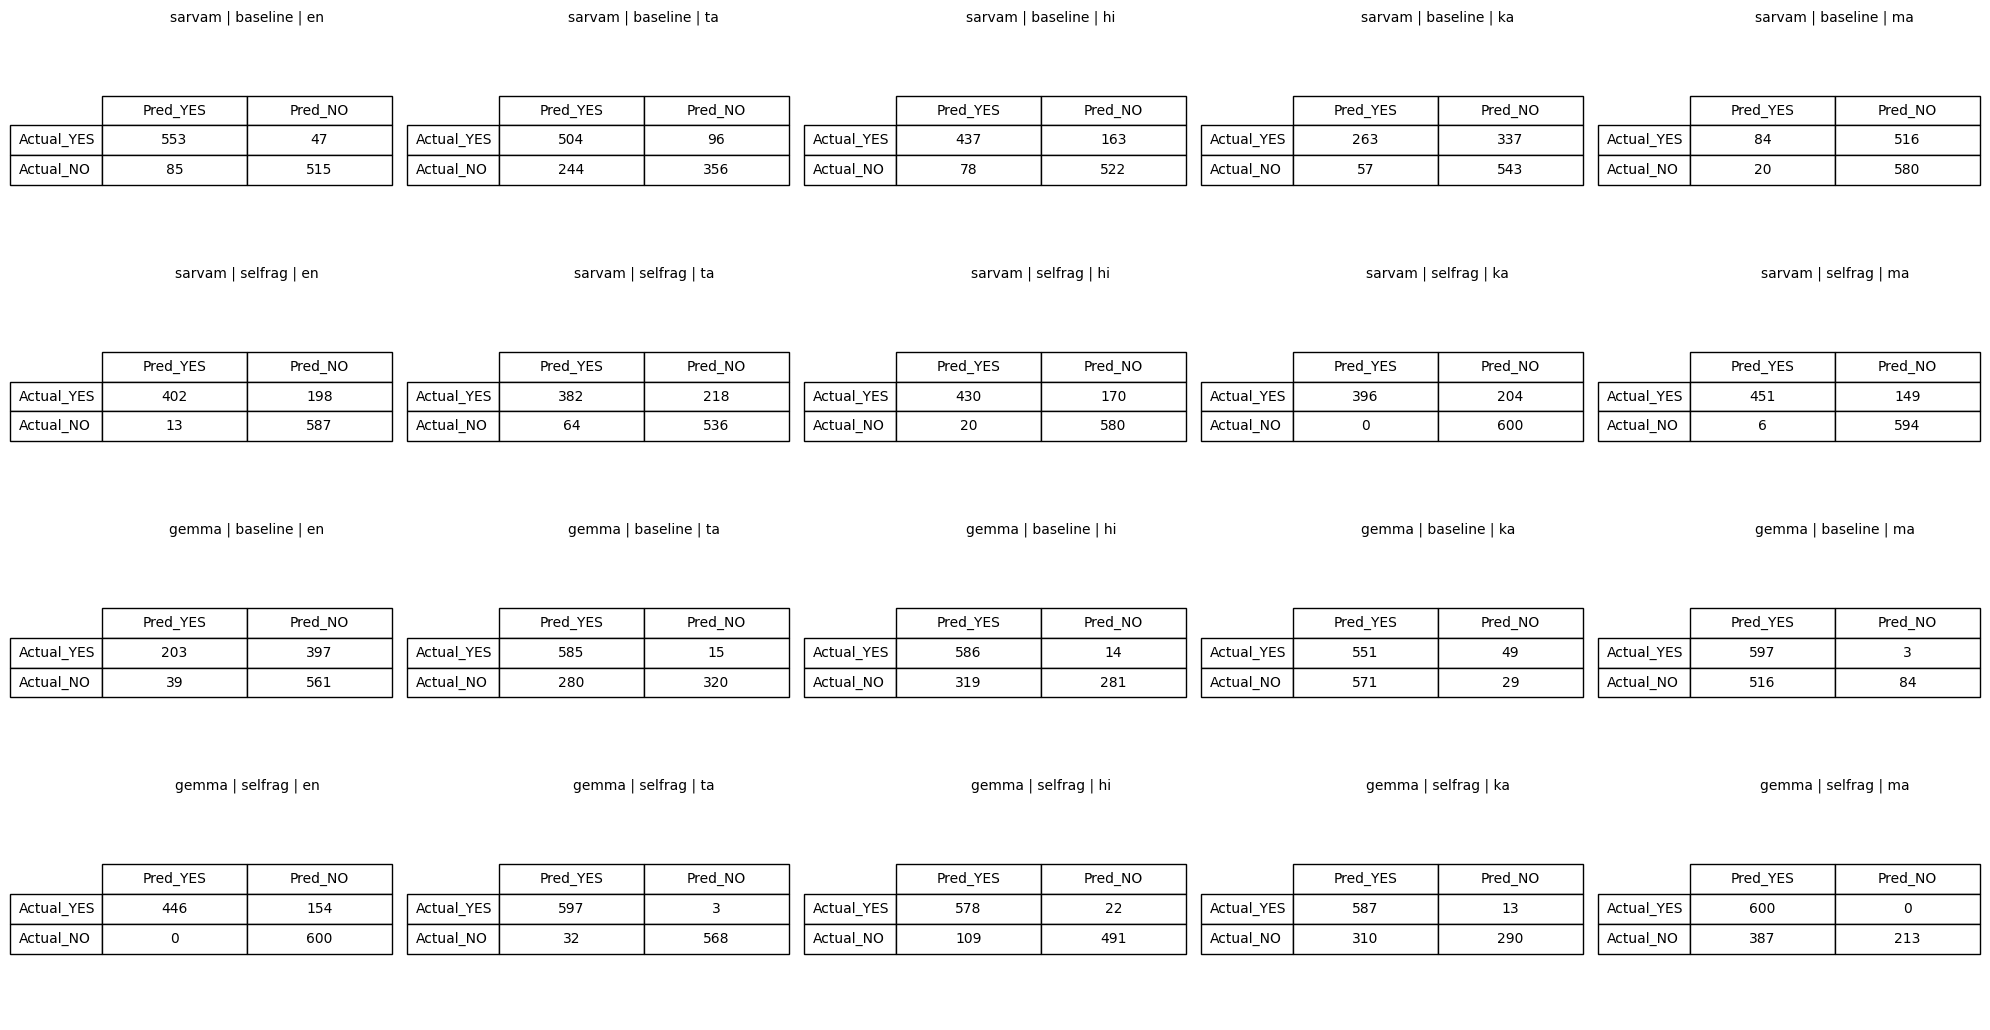

Saved: confusion_matrices_all.xlsx
Saved: macro_avg_across_languages.csv
Saved: deltas_vs_baseline_selfrag.csv


,model,config,macro_accuracy,macro_f1,total_n
0,gemma,baseline,0.632833,0.679307,6000
1,gemma,selfrag,0.828333,0.852577,6000
2,sarvam,baseline,0.726167,0.647077,6000
3,sarvam,selfrag,0.826333,0.798021,6000


,model,language,acc_baseline,f1_baseline,acc_selfrag,f1_selfrag,acc_delta,f1_delta
0,gemma,en,0.636667,0.482185,0.871667,0.852772,0.235000,0.370587
1,gemma,hi,0.722500,0.778738,0.890833,0.898213,0.168333,0.119475
2,gemma,ka,0.483333,0.639954,0.730833,0.784235,0.247500,0.144282
3,gemma,ma,0.567500,0.697023,0.677500,0.756144,0.110000,0.059121
4,gemma,ta,0.754167,0.798635,0.970833,0.971522,0.216667,0.172887
5,sarvam,en,0.890000,0.893376,0.824167,0.792118,-0.065833,-0.101258
6,sarvam,hi,0.799167,0.783857,0.841667,0.819048,0.042500,0.035191
7,sarvam,ka,0.671667,0.571739,0.830000,0.795181,0.158333,0.223442
8,sarvam,ma,0.553333,0.238636,0.870833,0.853359,0.317500,0.614722
9,sarvam,ta,0.716667,0.747774,0.765000,0.730402,0.048333,-0.017373


,model,config,language,TP,FP,FN,TN,precision_YES,recall_YES,f1_YES,accuracy,n
0,gemma,baseline,en,203,39,397,561,0.838843,0.338333,0.482185,0.636667,1200
1,gemma,baseline,hi,586,319,14,281,0.647514,0.976667,0.778738,0.722500,1200
2,gemma,baseline,ka,551,571,49,29,0.491087,0.918333,0.639954,0.483333,1200
3,gemma,baseline,ma,597,516,3,84,0.536388,0.995000,0.697023,0.567500,1200
4,gemma,baseline,ta,585,280,15,320,0.676301,0.975000,0.798635,0.754167,1200
5,gemma,selfrag,en,446,0,154,600,1.000000,0.743333,0.852772,0.871667,1200
6,gemma,selfrag,hi,578,109,22,491,0.841339,0.963333,0.898213,0.890833,1200
7,gemma,selfrag,ka,587,310,13,290,0.654404,0.978333,0.784235,0.730833,1200
8,gemma,selfrag,ma,600,387,0,213,0.607903,1.000000,0.756144,0.677500,1200
9,gemma,selfrag,ta,597,32,3,568,0.949126,0.995000,0.971522,0.970833,1200


In [23]:
# FULL END-TO-END CODE (baseline + selfrag only)
# Produces:
# 1) Accuracy comparison across all 5 languages (baseline vs selfrag) for both models
# 2) F1 comparison across all 5 languages (baseline vs selfrag) for both models
# 3) Confusion matrices as TABLES for all languages (per model x config)
# 4) Extra: Macro averages across languages + Delta vs baseline tables
# 5) Saves figures + exports confusion matrices + summaries to Excel/CSV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# -----------------------------
# 1) Utilities: tidy metrics df
# -----------------------------
def results_to_metrics_df(results: dict) -> pd.DataFrame:
    rows = []
    for model, model_dict in results.items():
        for config, config_dict in model_dict.items():
            for lang, r in config_dict.items():
                gold = r.get("gold", [])
                preds = r.get("predictions", [])
                rows.append({
                    "model": model,
                    "config": config,
                    "language": lang,
                    "accuracy": r.get("accuracy", np.nan),
                    "f1": r.get("f1", np.nan),
                    "n": len(gold) if isinstance(gold, (list, tuple)) else np.nan,
                    "has_preds": bool(preds) and bool(gold)
                })
    dfm = pd.DataFrame(rows)
    if not dfm.empty:
        dfm = dfm.sort_values(["model", "config", "language"]).reset_index(drop=True)
    return dfm


# ----------------------------------------
# 2) Plot: metric by language (2 configs)
# ----------------------------------------
def plot_metric_baseline_vs_selfrag(
    results: dict,
    metric: str,
    languages=('en','ta','hi','ka','ma'),
    models=('sarvam','gemma'),
    configs=('baseline','selfrag'),
    savepath=None
):
    dfm = results_to_metrics_df(results)

    # Filter to requested configs/models/languages
    dfm = dfm[
        dfm["model"].isin(models) &
        dfm["config"].isin(configs) &
        dfm["language"].isin(languages)
    ].copy()

    # Ensure ordering
    dfm["language"] = pd.Categorical(dfm["language"], categories=list(languages), ordered=True)
    dfm["model"] = pd.Categorical(dfm["model"], categories=list(models), ordered=True)
    dfm["config"] = pd.Categorical(dfm["config"], categories=list(configs), ordered=True)
    dfm = dfm.sort_values(["config", "language", "model"])

    fig, axes = plt.subplots(1, len(configs), figsize=(18, 6), sharey=True)
    if len(configs) == 1:
        axes = [axes]

    for ax, cfg in zip(axes, configs):
        sub = dfm[dfm["config"] == cfg].copy()

        x = np.arange(len(languages))
        width = 0.8 / max(1, len(models))  # bars per language

        for i, model in enumerate(models):
            vals = []
            for lang in languages:
                v = sub[(sub["model"] == model) & (sub["language"] == lang)][metric]
                vals.append(float(v.iloc[0]) if len(v) else np.nan)

            ax.bar(
                x + i*width - (len(models)-1)*width/2,
                vals,
                width,
                label=model
            )

        ax.set_title(f"{cfg}: {metric.upper()} by language")
        ax.set_xticks(x)
        ax.set_xticklabels(languages)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis="y")
        ax.set_xlabel("Language")
        if ax is axes[0]:
            ax.set_ylabel(metric.upper())
        ax.legend()

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"Saved: {savepath}")

    return fig


# ----------------------------------------------------
# 3) Confusion matrices as tables + summary dataframe
# ----------------------------------------------------
def confusion_tables_all(results: dict, labels=("YES", "NO")):
    cm_tables = {}   # key: (model, config, lang) -> confusion matrix DataFrame
    summary_rows = []

    for model, model_dict in results.items():
        for config, config_dict in model_dict.items():
            for lang, r in config_dict.items():
                gold = r.get("gold", [])
                pred = r.get("predictions", [])
                if not gold or not pred:
                    continue

                cm = confusion_matrix(gold, pred, labels=list(labels))
                cm_df = pd.DataFrame(
                    cm,
                    index=[f"Actual_{l}" for l in labels],
                    columns=[f"Pred_{l}" for l in labels]
                )
                cm_tables[(model, config, lang)] = cm_df

                # With labels=("YES","NO"), cm is:
                # [[TP, FN],
                #  [FP, TN]]
                TP = int(cm[0, 0])
                FN = int(cm[0, 1])
                FP = int(cm[1, 0])
                TN = int(cm[1, 1])

                precision = precision_score(gold, pred, pos_label="YES", zero_division=0)
                recall = recall_score(gold, pred, pos_label="YES", zero_division=0)
                f1v = f1_score(gold, pred, pos_label="YES", zero_division=0)
                acc = accuracy_score(gold, pred)

                summary_rows.append({
                    "model": model,
                    "config": config,
                    "language": lang,
                    "TP": TP, "FP": FP, "FN": FN, "TN": TN,
                    "precision_YES": precision,
                    "recall_YES": recall,
                    "f1_YES": f1v,
                    "accuracy": acc,
                    "n": len(gold)
                })

    summary_df = pd.DataFrame(summary_rows)
    if not summary_df.empty:
        summary_df = summary_df.sort_values(["model", "config", "language"]).reset_index(drop=True)

    return cm_tables, summary_df


# -----------------------------------------
# 4) Render confusion tables in one figure
# -----------------------------------------
def plot_confusion_tables_grid(
    cm_tables: dict,
    models=('sarvam','gemma'),
    configs=('baseline','selfrag'),
    languages=('en','ta','hi','ka','ma'),
    savepath=None
):
    # Grid: rows = models * configs, cols = languages
    nrows = len(models) * len(configs)
    ncols = len(languages)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.6*nrows))

    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.array([axes])
    elif ncols == 1:
        axes = np.array([[ax] for ax in axes])

    row = 0
    for model in models:
        for cfg in configs:
            for col, lang in enumerate(languages):
                ax = axes[row, col]
                key = (model, cfg, lang)
                ax.axis("off")

                if key not in cm_tables:
                    ax.set_title(f"{model} | {cfg} | {lang}\n(no data)", fontsize=10)
                    continue

                cm_df = cm_tables[key]
                ax.set_title(f"{model} | {cfg} | {lang}", fontsize=10)

                # Create a matplotlib table
                tbl = ax.table(
                    cellText=cm_df.values,
                    rowLabels=cm_df.index.tolist(),
                    colLabels=cm_df.columns.tolist(),
                    loc="center",
                    cellLoc="center"
                )
                tbl.auto_set_font_size(False)
                tbl.set_fontsize(10)
                tbl.scale(1.0, 1.4)

            row += 1

    plt.tight_layout()

    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
        print(f"Saved: {savepath}")

    return fig


# --------------------------------
# 5) Macro averages + deltas table
# --------------------------------
def macro_average_across_languages(results: dict, languages=('en','ta','hi','ka','ma')):
    dfm = results_to_metrics_df(results)
    if dfm.empty:
        return dfm
    dfm = dfm[dfm["language"].isin(languages)]
    macro = (dfm.groupby(["model", "config"], as_index=False)
               .agg(macro_accuracy=("accuracy", "mean"),
                    macro_f1=("f1", "mean"),
                    total_n=("n", "sum")))
    return macro.sort_values(["model","config"]).reset_index(drop=True)

def deltas_vs_baseline(results: dict, languages=('en','ta','hi','ka','ma'), target_config="selfrag"):
    dfm = results_to_metrics_df(results)
    if dfm.empty:
        return dfm
    dfm = dfm[dfm["language"].isin(languages)]

    base = dfm[dfm["config"] == "baseline"][["model","language","accuracy","f1"]].rename(
        columns={"accuracy":"acc_baseline","f1":"f1_baseline"}
    )
    tgt = dfm[dfm["config"] == target_config][["model","language","accuracy","f1"]].rename(
        columns={"accuracy":f"acc_{target_config}","f1":f"f1_{target_config}"}
    )

    out = base.merge(tgt, on=["model","language"], how="inner")
    out["acc_delta"] = out[f"acc_{target_config}"] - out["acc_baseline"]
    out["f1_delta"] = out[f"f1_{target_config}"] - out["f1_baseline"]
    return out.sort_values(["model","language"]).reset_index(drop=True)


# ----------------------------
# 6) Optional: export to excel
# ----------------------------
def save_confusions_to_excel(cm_tables, cm_summary, path="confusion_matrices_all.xlsx"):
    with pd.ExcelWriter(path, engine="openpyxl") as writer:
        cm_summary.to_excel(writer, sheet_name="summary", index=False)

        for (model, config, lang), cm_df in cm_tables.items():
            sheet = f"{model}_{config}_{lang}"
            sheet = sheet[:31]  # Excel sheet name limit
            cm_df.to_excel(writer, sheet_name=sheet)

    print(f"Saved: {path}")
    return path


# ============================
# RUN THESE ON YOUR all_results
# ============================

# Assumes you already have: all_results = run_full_evaluation(df)
# and your run_full_evaluation only includes baseline + selfrag

LANGUAGES = ['en', 'ta', 'hi', 'ka', 'ma']
MODELS = ['sarvam', 'gemma']
CONFIGS = ['baseline', 'selfrag']

# 1) Accuracy comparison across all languages
fig_acc = plot_metric_baseline_vs_selfrag(
    all_results,
    metric="accuracy",
    languages=LANGUAGES,
    models=MODELS,
    configs=CONFIGS,
    savepath="accuracy_all_languages_baseline_vs_selfrag.png"
)
plt.show()

# 2) F1 comparison across all languages
fig_f1 = plot_metric_baseline_vs_selfrag(
    all_results,
    metric="f1",
    languages=LANGUAGES,
    models=MODELS,
    configs=CONFIGS,
    savepath="f1_all_languages_baseline_vs_selfrag.png"
)
plt.show()

# 3) Confusion matrices as tables (all languages, both models, both configs)
cm_tables, cm_summary = confusion_tables_all(all_results, labels=("YES","NO"))

# Save the summary table to CSV
cm_summary.to_csv("confusion_summary_all_languages.csv", index=False)
print("Saved: confusion_summary_all_languages.csv")

# Plot the confusion tables in a grid and save
fig_cm = plot_confusion_tables_grid(
    cm_tables,
    models=MODELS,
    configs=CONFIGS,
    languages=LANGUAGES,
    savepath="confusion_tables_all_languages.png"
)
plt.show()

# Export all confusion tables + summary to Excel
save_confusions_to_excel(cm_tables, cm_summary, path="confusion_matrices_all.xlsx")

# 4) Extras: macro averages + deltas
macro_df = macro_average_across_languages(all_results, languages=LANGUAGES)
delta_df = deltas_vs_baseline(all_results, languages=LANGUAGES, target_config="selfrag")

# Save extras
macro_df.to_csv("macro_avg_across_languages.csv", index=False)
delta_df.to_csv("deltas_vs_baseline_selfrag.csv", index=False)
print("Saved: macro_avg_across_languages.csv")
print("Saved: deltas_vs_baseline_selfrag.csv")

# Display if you're in a notebook
try:
    display(macro_df)
    display(delta_df)
    display(cm_summary)
except NameError:
    print("\nMacro averages:\n", macro_df)
    print("\nDeltas vs baseline:\n", delta_df)
    print("\nConfusion summary:\n", cm_summary)


## Detailed Results Summary

In [24]:
import pandas as pd
import numpy as np

def create_results_summary(results: dict,
                           languages=('en','ta','hi','ka','ma'),
                           models=('sarvam','gemma'),
                           configs=('baseline','selfrag')) -> pd.DataFrame:
    """
    Create a detailed summary table of all results (baseline + selfrag).
    """
    summary_data = []

    for model in models:
        if model not in results:
            continue
        for config in configs:
            if config not in results[model]:
                continue
            for lang in languages:
                if lang not in results[model][config]:
                    continue

                r = results[model][config][lang]
                summary_data.append({
                    "Model": model.capitalize(),
                    "Configuration": config.replace('_', ' ').title(),
                    "Language": lang.upper(),
                    "Accuracy": float(r["accuracy"]),
                    "F1 Score": float(r["f1"]),
                    "N": len(r.get("gold", []))
                })

    df_summary = pd.DataFrame(summary_data)
    if not df_summary.empty:
        df_summary = df_summary.sort_values(["Model","Configuration","Language"]).reset_index(drop=True)

    # Format-only copy for printing
    df_print = df_summary.copy()
    if not df_print.empty:
        df_print["Accuracy"] = df_print["Accuracy"].map(lambda x: f"{x:.3f}")
        df_print["F1 Score"] = df_print["F1 Score"].map(lambda x: f"{x:.3f}")

    return df_summary, df_print


def best_configuration_by_macro_avg(df_summary: pd.DataFrame) -> pd.DataFrame:
    """
    Best configuration for each model based on macro average across languages.
    """
    macro = (df_summary.groupby(["Model","Configuration"], as_index=False)
                     .agg(Macro_Accuracy=("Accuracy","mean"),
                          Macro_F1=("F1 Score","mean"),
                          Total_N=("N","sum")))
    best = (macro.sort_values(["Model","Macro_Accuracy","Macro_F1"], ascending=[True, False, False])
                 .groupby("Model", as_index=False)
                 .head(1)
                 .reset_index(drop=True))
    return macro, best


def best_configuration_en_only(results: dict, models=('sarvam','gemma'), configs=('baseline','selfrag')):
    rows = []
    for model in models:
        best_acc = -1
        best_cfg = None
        for cfg in configs:
            if model in results and cfg in results[model] and "en" in results[model][cfg]:
                acc = results[model][cfg]["en"]["accuracy"]
                if acc > best_acc:
                    best_acc = acc
                    best_cfg = cfg
        if best_cfg is not None:
            rows.append({
                "Model": model.upper(),
                "Best Configuration (EN)": best_cfg.replace("_"," ").title(),
                "Accuracy (EN)": results[model][best_cfg]["en"]["accuracy"],
                "F1 (EN)": results[model][best_cfg]["en"]["f1"]
            })
    df = pd.DataFrame(rows)
    if not df.empty:
        df["Accuracy (EN)"] = df["Accuracy (EN)"].map(lambda x: f"{x:.3f}")
        df["F1 (EN)"] = df["F1 (EN)"].map(lambda x: f"{x:.3f}")
    return df


def average_improvements_over_baseline(df_summary: pd.DataFrame) -> pd.DataFrame:
    """
    Average improvements over baseline across languages for each model.
    """
    base = df_summary[df_summary["Configuration"] == "Baseline"][["Model","Language","Accuracy","F1 Score"]].rename(
        columns={"Accuracy":"Acc_Baseline","F1 Score":"F1_Baseline"}
    )
    tgt = df_summary[df_summary["Configuration"] == "Selfrag"][["Model","Language","Accuracy","F1 Score"]].rename(
        columns={"Accuracy":"Acc_Selfrag","F1 Score":"F1_Selfrag"}
    )

    merged = base.merge(tgt, on=["Model","Language"], how="inner")
    merged["Acc_Delta"] = merged["Acc_Selfrag"] - merged["Acc_Baseline"]
    merged["F1_Delta"] = merged["F1_Selfrag"] - merged["F1_Baseline"]

    avg = (merged.groupby("Model", as_index=False)
                 .agg(Avg_Acc_Improvement=("Acc_Delta","mean"),
                      Avg_F1_Improvement=("F1_Delta","mean")))

    # Human-friendly percent columns
    avg["Avg_Acc_Improvement_%"] = avg["Avg_Acc_Improvement"].map(lambda x: f"{x*100:.1f}%")
    avg["Avg_F1_Improvement_%"] = avg["Avg_F1_Improvement"].map(lambda x: f"{x*100:.1f}%")

    return merged, avg


# ============================
# RUN
# ============================

LANGUAGES = ['en', 'ta', 'hi', 'ka', 'ma']
MODELS = ['sarvam', 'gemma']
CONFIGS = ['baseline', 'selfrag']

summary_df, summary_print_df = create_results_summary(
    all_results,
    languages=LANGUAGES,
    models=MODELS,
    configs=CONFIGS
)

print("\n" + "="*70)
print("DETAILED RESULTS SUMMARY (ALL LANGUAGES | BASELINE + SELFRAG)")
print("="*70)
if summary_print_df.empty:
    print("No rows found. Check that all_results has the expected structure.")
else:
    print(summary_print_df.to_string(index=False))

# Best config per model (macro average across languages)
macro_df, best_macro_df = best_configuration_by_macro_avg(summary_df)

print("\n" + "="*70)
print("BEST CONFIGURATIONS (MACRO AVERAGE ACROSS LANGUAGES)")
print("="*70)
if best_macro_df.empty:
    print("No rows found.")
else:
    out = best_macro_df.copy()
    out["Macro_Accuracy"] = out["Macro_Accuracy"].map(lambda x: f"{x:.3f}")
    out["Macro_F1"] = out["Macro_F1"].map(lambda x: f"{x:.3f}")
    print(out.to_string(index=False))

# Optional: Best config per model (English only)
print("\n" + "="*70)
print("BEST CONFIGURATIONS (ENGLISH ONLY)")
print("="*70)
best_en_df = best_configuration_en_only(all_results, models=MODELS, configs=CONFIGS)
if best_en_df.empty:
    print("No EN rows found.")
else:
    print(best_en_df.to_string(index=False))

# Average improvements over baseline (across languages)
merged_impr_df, avg_impr_df = average_improvements_over_baseline(summary_df)

print("\n" + "="*70)
print("AVERAGE IMPROVEMENTS OVER BASELINE (ACROSS LANGUAGES)")
print("="*70)
if avg_impr_df.empty:
    print("No rows found.")
else:
    # show both raw delta and percent
    out = avg_impr_df[["Model","Avg_Acc_Improvement_%","Avg_F1_Improvement_%"]].copy()
    print(out.to_string(index=False))

# Save outputs
summary_df.to_csv("hallucination_detection_results_all_languages.csv", index=False)
macro_df.to_csv("macro_by_model_config.csv", index=False)
best_macro_df.to_csv("best_config_macro.csv", index=False)
merged_impr_df.to_csv("deltas_baseline_vs_selfrag_by_language.csv", index=False)
avg_impr_df.to_csv("avg_improvements_over_baseline.csv", index=False)

print("\n" + "="*70)
print("Saved CSVs:")
print(" - hallucination_detection_results_all_languages.csv")
print(" - macro_by_model_config.csv")
print(" - best_config_macro.csv")
print(" - deltas_baseline_vs_selfrag_by_language.csv")
print(" - avg_improvements_over_baseline.csv")
print("="*70)



DETAILED RESULTS SUMMARY (ALL LANGUAGES | BASELINE + SELFRAG)
 Model Configuration Language Accuracy F1 Score    N
 Gemma      Baseline       EN    0.637    0.482 1200
 Gemma      Baseline       HI    0.723    0.779 1200
 Gemma      Baseline       KA    0.483    0.640 1200
 Gemma      Baseline       MA    0.568    0.697 1200
 Gemma      Baseline       TA    0.754    0.799 1200
 Gemma       Selfrag       EN    0.872    0.853 1200
 Gemma       Selfrag       HI    0.891    0.898 1200
 Gemma       Selfrag       KA    0.731    0.784 1200
 Gemma       Selfrag       MA    0.677    0.756 1200
 Gemma       Selfrag       TA    0.971    0.972 1200
Sarvam      Baseline       EN    0.890    0.893 1200
Sarvam      Baseline       HI    0.799    0.784 1200
Sarvam      Baseline       KA    0.672    0.572 1200
Sarvam      Baseline       MA    0.553    0.239 1200
Sarvam      Baseline       TA    0.717    0.748 1200
Sarvam       Selfrag       EN    0.824    0.792 1200
Sarvam       Selfrag       HI    0.8

## Error Analysis

In [ ]:
# Perform error analysis
def error_analysis(results: Dict, df: pd.DataFrame, model_name: str = 'sarvam', config: str = 'selfrag'):
    """
    Analyze errors made by the model
    """
    predictions = results[model_name][config]['en']['predictions']
    gold = results[model_name][config]['en']['gold']

    # Find misclassified samples
    errors = []
    for i, (pred, true) in enumerate(zip(predictions, gold)):
        if pred != true:
            errors.append({
                'index': i,
                'statement': df.iloc[i]['statement'],
                'topic': df.iloc[i]['topic'],
                'true_label': true,
                'predicted': pred,
                'is_hallucination': df.iloc[i]['isHallucination']
            })

    error_df = pd.DataFrame(errors)

    print(f"\nError Analysis for {model_name.upper()} ({config})")
    print("="*60)
    print(f"Total errors: {len(errors)} / {len(predictions)} ({len(errors)/len(predictions)*100:.1f}%)")

    if len(errors) > 0:
        # Analyze error types
        false_positives = error_df[error_df['predicted'] == 'YES']['is_hallucination'].value_counts()
        false_negatives = error_df[error_df['predicted'] == 'NO']['is_hallucination'].value_counts()

        print("\nError Types:")
        print(f"  False Positives (predicted YES, actually NO): {len(error_df[error_df['predicted'] == 'YES'])}")
        print(f"  False Negatives (predicted NO, actually YES): {len(error_df[error_df['predicted'] == 'NO'])}")

        # Topics with most errors
        print("\nTopics with most errors:")
        topic_errors = error_df['topic'].value_counts().head(5)
        for topic, count in topic_errors.items():
            print(f"  {topic}: {count} errors")

        # Sample errors
        print("\nSample misclassified statements:")
        for _, row in error_df.head(3).iterrows():
            print(f"\n  Statement: {row['statement'][:100]}...")
            print(f"  Topic: {row['topic']}")
            print(f"  True: {row['true_label']}, Predicted: {row['predicted']}")

    return error_df

# Analyze errors for both models
print("\n" + "="*60)
print("ERROR ANALYSIS")
print("="*60)

sarvam_errors = error_analysis(all_results, df_sample, 'sarvam', 'selfrag')
gemma_errors = error_analysis(all_results, df_sample, 'gemma', 'selfrag')

# Save error analysis
if len(sarvam_errors) > 0:
    sarvam_errors.to_csv('sarvam_errors.csv', index=False)
if len(gemma_errors) > 0:
    gemma_errors.to_csv('gemma_errors.csv', index=False)

print("\nError analysis saved to CSV files.")

## Save All Results

In [ ]:
# Save all results to JSON for later analysis
import json

# Prepare results for JSON serialization
def prepare_for_json(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: prepare_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [prepare_for_json(item) for item in obj]
    else:
        return obj

# Save results
results_to_save = prepare_for_json(all_results)

with open('hallucination_detection_full_results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print("\nAll results saved to 'hallucination_detection_full_results.json'")

# Create a final summary
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)

print("\n📊 Evaluation Complete!")
print(f"\n✅ Evaluated {len(df_sample)} statements")
print(f"✅ Tested 2 models: Sarvam-1 and Gemma-2")
print(f"✅ Compared 3 configurations: Baseline, With Context, Self-RAG")
print(f"✅ Tested across {len(['en', 'hi'])} languages")

print("\n🏆 Best Performers:")
best_overall = 0
best_model = ""
best_conf = ""

for model in ['sarvam', 'gemma']:
    for config in ['baseline', 'with_context', 'selfrag']:
        acc = all_results[model][config]['en']['accuracy']
        if acc > best_overall:
            best_overall = acc
            best_model = model
            best_conf = config

print(f"  🥇 {best_model.upper()} with {best_conf.replace('_', ' ').title()}: {best_overall:.3f} accuracy")

print("\n📁 Output Files:")
print("  • hallucination_detection_results.png")
print("  • hallucination_detection_results.csv")
print("  • hallucination_detection_full_results.json")
print("  • sarvam_errors.csv")
print("  • gemma_errors.csv")

print("\n" + "="*60)
print("Analysis complete! 🎉")
print("="*60)